In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html


In [ ]:

!nvcc --version
!python -c "import torch; print(torch.version.cuda)"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
11.1


In [ ]:
import copy
import torch
import deepsnap
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from sklearn.metrics import f1_score
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from torch_sparse import SparseTensor, matmul

import torch_geometric
print(torch.__version__)
print(torch_geometric.__version__)

1.9.0+cu111
2.0.2


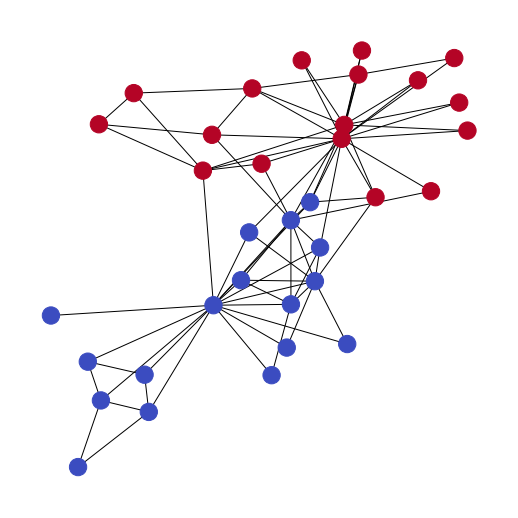

In [ ]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import copy

from pylab import show
G = nx.karate_club_graph()
community_map = {}
for node in G.nodes(data=True):
  if node[1]["club"] == "Mr. Hi":
    community_map[node[0]] = 0
  else:
    community_map[node[0]] = 1
node_color = []
color_map = {0: 0, 1: 1}
node_color = [color_map[community_map[node]] for node in G.nodes()]
pos = nx.spring_layout(G)
plt.figure(figsize=(7, 7))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color)
show()

In [ ]:
import torch

def assign_node_types(G, community_map):

  node_types = {node: 'n'+ str(community_map[node]) for node in G.nodes()}
  nx.set_node_attributes(G, node_types, 'node_type')
  

def assign_node_labels(G, community_map):

  nx.set_node_attributes(G, community_map, 'node_label')


def assign_node_features(G):

  nx.set_node_attributes(G, torch.Tensor([1., 1., 1., 1., 1.]), 'node_feature')


assign_node_types(G, community_map)
assign_node_labels(G, community_map)
assign_node_features(G)


node_id = 20
print (f"Node {node_id} has properties:", G.nodes(data=True)[node_id])

Node 20 has properties: {'club': 'Officer', 'node_type': 'n1', 'node_label': 1, 'node_feature': tensor([1., 1., 1., 1., 1.])}


In [ ]:
def assign_edge_types(G, community_map):


  edge_map = {'00': 'e0', '01': 'e2', '10': 'e2', '11': 'e1'}
  edge_types = {edge: edge_map[str(community_map[edge[0]]) + str(community_map[edge[1]])] for edge in G.edges}
  nx.set_edge_attributes(G, edge_types, 'edge_type')


if 'IS_GRADESCOPE_ENV' not in os.environ:
  assign_edge_types(G, community_map)

  edge_idx = 15
  n1 = 0
  n2 = 31
  edge = list(G.edges(data=True))[edge_idx]
  print (f"Edge ({edge[0]}, {edge[1]}) has properties:", edge[2])
  print (f"Node {n1} has properties:", G.nodes(data=True)[n1])
  print (f"Node {n2} has properties:", G.nodes(data=True)[n2])

Edge (0, 31) has properties: {'edge_type': 'e2'}
Node 0 has properties: {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': tensor([1., 1., 1., 1., 1.])}
Node 31 has properties: {'club': 'Officer', 'node_type': 'n1', 'node_label': 1, 'node_feature': tensor([1., 1., 1., 1., 1.])}


In [ ]:
from deepsnap.hetero_graph import HeteroGraph
hete = HeteroGraph(G_orig)

In [ ]:
class HeteroGNNConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels_src, in_channels_dst, out_channels):
        super(HeteroGNNConv, self).__init__(aggr="mean")

        self.in_channels_src = in_channels_src
        self.in_channels_dst = in_channels_dst
        self.out_channels = out_channels

        self.lin_dst = nn.Linear(self.in_channels_dst, self.out_channels)
        self.lin_src = nn.Linear(self.in_channels_src, self.out_channels)
        self.lin_update = nn.Linear(self.out_channels*2, self.out_channels)


    def forward(
        self,
        node_feature_src,
        node_feature_dst,
        edge_index,
        size=None
    ):
        return self.propagate(
            edge_index,
            size=size,
            node_feature_src=node_feature_src,
            node_feature_dst=node_feature_dst,
        )


    def message_and_aggregate(self, edge_index, node_feature_src):

        out = matmul(edge_index, node_feature_src, reduce='mean')


        return out

    def update(self, aggr_out, node_feature_dst):
        node_feature_dst = self.lin_dst(node_feature_dst)
        aggr_out = self.lin_src(aggr_out)       
        combined = torch.cat((node_feature_dst, aggr_out), dim=-1)
        aggr_out = self.lin_update(combined)

        return aggr_out

In [ ]:
class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
    def __init__(self, convs, args, aggr=None):

        super(HeteroGNNWrapperConv, self).__init__(convs, None)
        self.aggr = aggr

        self.mapping = {}
        self.alpha = None

        self.attn_proj = None

        if self.aggr == "attn":

            self.attn_proj = nn.Sequential(
                nn.Linear(args['hidden_size'], args['attn_size']),
                nn.Tanh(),
                nn.Linear(args['attn_size'], 1, bias=False)
            )

    
    def reset_parameters(self):
        super(HeteroGNNWrapperConv, self).reset_parameters()
        if self.aggr == "attn":
            for layer in self.attn_proj.children():
                layer.reset_parameters()
    
    def forward(self, node_features, edge_indices):
        message_type_emb = {}
        for message_key, message_type in edge_indices.items():
            src_type, edge_type, dst_type = message_key
            node_feature_src = node_features[src_type]
            node_feature_dst = node_features[dst_type]
            edge_index = edge_indices[message_key]
            message_type_emb[message_key] = (
                self.convs[message_key](
                    node_feature_src,
                    node_feature_dst,
                    edge_index,
                )
            )
        node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
        mapping = {}        
        for (src, edge_type, dst), item in message_type_emb.items():
            mapping[len(node_emb[dst])] = (src, edge_type, dst)
            node_emb[dst].append(item)
        self.mapping = mapping
        for node_type, embs in node_emb.items():
            if len(embs) == 1:
                node_emb[node_type] = embs[0]
            else:
                node_emb[node_type] = self.aggregate(embs)
        return node_emb
    
    def aggregate(self, xs):
        if self.aggr == "mean":


            h_v_lm = torch.stack(xs)                     
            h_v_l = torch.mean(torch.stack(xs), dim=0)   

            return h_v_l


        elif self.aggr == "attn":
            h_v_lm = torch.stack(xs, dim=0)                 
            
            e_m = self.attn_proj(h_v_lm)                    
            e_m = torch.mean(e_m, dim=-1)                  

            self.alpha = torch.softmax(e_m, dim=0).detach() 
            
            h_v_l = self.alpha.unsqueeze(-1) * h_v_lm      
            h_v_l = torch.sum(h_v_l, dim=0)                 

            return h_v_l

In [ ]:
def generate_convs(hetero_graph, conv, hidden_size, first_layer=False):


    convs = {}

    for message_type in hetero_graph.message_types:
      if first_layer:

        num_node_feat_src = hetero_graph.num_node_features(message_type[0])
        num_node_feat_dst = hetero_graph.num_node_features(message_type[-1])
        convs[message_type] = conv(
            in_channels_src=num_node_feat_src,
            in_channels_dst=num_node_feat_dst,
            out_channels=hidden_size,
        )
      else:
        convs[message_type] = conv(
            in_channels_src=hidden_size,
            in_channels_dst=hidden_size,
            out_channels=hidden_size,
        )

    
    return convs

In [ ]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hetero_graph, args, aggr="mean"):
        super(HeteroGNN, self).__init__()

        self.aggr = aggr
        self.hidden_size = args['hidden_size']

        self.convs1 = None
        self.convs2 = None

        self.bns1 = nn.ModuleDict()
        self.bns2 = nn.ModuleDict()
        self.relus1 = nn.ModuleDict()
        self.relus2 = nn.ModuleDict()
        self.post_mps = nn.ModuleDict()

        convs1_dict = generate_convs(
            hetero_graph=hetero_graph, 
            conv=HeteroGNNConv,
            hidden_size=self.hidden_size,
            first_layer=True,
        )
        self.convs1 = HeteroGNNWrapperConv(
            convs=convs1_dict,
            args=args,
            aggr=self.aggr
        )
        convs2_dict = generate_convs(
            hetero_graph=hetero_graph, 
            conv=HeteroGNNConv,
            hidden_size=self.hidden_size,
            first_layer=False,
        )
        self.convs2 = HeteroGNNWrapperConv(
            convs=convs2_dict,
            args=args,
            aggr=self.aggr
        )
        
        # Step 2, 3, 4
        for node_type in hetero_graph.node_types:
          self.bns1[node_type] = torch.nn.BatchNorm1d(self.hidden_size, eps=1.)
          self.relus1[node_type] = torch.nn.LeakyReLU()
          self.bns2[node_type] = torch.nn.BatchNorm1d(self.hidden_size, eps=1.)
          self.relus2[node_type] = torch.nn.LeakyReLU()
          self.post_mps[node_type] = nn.Linear(
              self.hidden_size,
              hetero_graph.num_node_labels(node_type)
          )

    def forward(self, node_feature, edge_index):

        x = node_feature

        x = self.convs1(x, edge_index)
        x = forward_op(x, self.bns1)
        x = forward_op(x, self.relus1)

        x = self.convs2(x, edge_index)
        x = forward_op(x, self.bns2)
        x = forward_op(x, self.relus2)

        x = forward_op(x, self.post_mps)
        
        return x

    def loss(self, preds, y, indices):
        
        loss = 0
        loss_func = F.cross_entropy

        for node_type in preds:                            
          index = indices[node_type]                    
          pred = preds[node_type][index]                    
          loss += loss_func(pred, y[node_type][index])      

        return loss

In [ ]:
import pandas as pd

def train(model, optimizer, hetero_graph, train_idx):
    model.train()
    optimizer.zero_grad()
    preds = model(hetero_graph.node_feature, hetero_graph.edge_index)

    loss = None
    loss = model.loss(
        preds=preds,
        y=hetero_graph.node_label,
        indices=train_idx,
    )

    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, graph, indices, best_model=None, best_val=0, save_preds=False, agg_type=None):
    model.eval()
    accs = []
    for i, index in enumerate(indices):
        preds = model(graph.node_feature, graph.edge_index)
        num_node_types = 0
        micro = 0
        macro = 0
        for node_type in preds:
            idx = index[node_type]
            pred = preds[node_type][idx]
            pred = pred.max(1)[1]
            label_np = graph.node_label[node_type][idx].cpu().numpy()
            pred_np = pred.cpu().numpy()
            micro = f1_score(label_np, pred_np, average='micro')
            macro = f1_score(label_np, pred_np, average='macro')
            num_node_types += 1
                  
        micro /= num_node_types
        macro /= num_node_types
        accs.append((micro, macro))

        if save_preds and i == 2:
          print ("Saving Heterogeneous Node Prediction Model Predictions with Agg:", agg_type)
          print()

          data = {}
          data['pred'] = pred_np
          data['label'] = label_np

          df = pd.DataFrame(data=data)

          df.to_csv('ACM-Node-' + agg_type + 'Agg.csv', sep=',', index=False)

    if accs[1][0] > best_val:
        best_val = accs[1][0]
        best_model = copy.deepcopy(model)
    return accs, best_model, best_val

In [ ]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 64,
    'epochs': 100,
    'weight_decay': 1e-5,
    'lr': 0.003,
    'attn_size': 32,
}

In [ ]:

print("Device: {}".format(args['device']))

# Load the data
data = torch.load("acm.pkl")

# Message types
message_type_1 = ("paper", "author", "paper")
message_type_2 = ("paper", "subject", "paper")

# Dictionary of edge indices
edge_index = {}
edge_index[message_type_1] = data['pap']
edge_index[message_type_2] = data['psp']

# Dictionary of node features
node_feature = {}
node_feature["paper"] = data['feature']

# Dictionary of node labels
node_label = {}
node_label["paper"] = data['label']

# Load the train, validation and test indices
train_idx = {"paper": data['train_idx'].to(args['device'])}
val_idx = {"paper": data['val_idx'].to(args['device'])}
test_idx = {"paper": data['test_idx'].to(args['device'])}

# Construct a deepsnap tensor backend HeteroGraph
hetero_graph = HeteroGraph(
    node_feature=node_feature,
    node_label=node_label,
    edge_index=edge_index,
    directed=True
)

print(f"ACM heterogeneous graph: {hetero_graph.num_nodes()} nodes, {hetero_graph.num_edges()} edges")

# Node feature and node label to device
for key in hetero_graph.node_feature:
    hetero_graph.node_feature[key] = hetero_graph.node_feature[key].to(args['device'])
for key in hetero_graph.node_label:
    hetero_graph.node_label[key] = hetero_graph.node_label[key].to(args['device'])

# Edge_index to sparse tensor and to device
for key in hetero_graph.edge_index:
    edge_index = hetero_graph.edge_index[key]
    adj = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(hetero_graph.num_nodes('paper'), hetero_graph.num_nodes('paper')))
    hetero_graph.edge_index[key] = adj.t().to(args['device'])
print(hetero_graph.edge_index[message_type_1])
print(hetero_graph.edge_index[message_type_2])

Device: cuda
ACM heterogeneous graph: {'paper': 3025} nodes, {('paper', 'author', 'paper'): 26256, ('paper', 'subject', 'paper'): 2207736} edges
SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024], device='cuda:0'),
             col=tensor([   8,   20,   51,  ..., 2948, 2983, 2991], device='cuda:0'),
             size=(3025, 3025), nnz=26256, density=0.29%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024], device='cuda:0'),
             col=tensor([  75,  434,  534,  ..., 3020, 3021, 3022], device='cuda:0'),
             size=(3025, 3025), nnz=2207736, density=24.13%)


In [ ]:

best_model = None
best_val = 0

model = HeteroGNN(hetero_graph, args, aggr="mean").to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

for epoch in range(args['epochs']):
    loss = train(model, optimizer, hetero_graph, train_idx)
    accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
    print(
        f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
        f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
        f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
        f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
    )
best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx], save_preds=True, agg_type="Mean")
print(
    f"Best model: "
    f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
    f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
    f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
)

Epoch 1: loss 1.09882, train micro 33.33%, train macro 16.67%, valid micro 33.33%, valid macro 16.67%, test micro 35.81%, test macro 17.58%
Epoch 2: loss 1.09196, train micro 49.83%, train macro 41.09%, valid micro 38.0%, valid macro 25.46%, test micro 39.95%, test macro 25.92%
Epoch 3: loss 1.06808, train micro 65.67%, train macro 54.51%, valid micro 65.0%, valid macro 54.34%, test micro 64.47%, test macro 53.97%
Epoch 4: loss 1.01791, train micro 66.33%, train macro 54.96%, valid micro 66.33%, valid macro 55.31%, test micro 65.04%, test macro 54.28%
Epoch 5: loss 0.92926, train micro 66.83%, train macro 55.98%, valid micro 66.0%, valid macro 55.0%, test micro 65.36%, test macro 54.43%
Epoch 6: loss 0.7961, train micro 67.33%, train macro 56.78%, valid micro 66.0%, valid macro 55.0%, test micro 65.41%, test macro 54.42%
Epoch 7: loss 0.63329, train micro 67.67%, train macro 57.41%, valid micro 66.33%, valid macro 55.64%, test micro 65.46%, test macro 54.44%
Epoch 8: loss 0.47548, trai